## Eng+Wales well-mixed model MCMC

This is the MCMC notebook.  There are various model variants as encoded by `expt_params_local` and `model_local`, which are shared by the notebooks in a given directory.

On running, this notebook *either* starts a new MCMC computation, *or* picks up an existing sampler and continues MCMC from that point.  This is controlled by `startMCMC`.

**Note** : Depending on parameters and compute power, this may take many hours to run.

Outputs of this notebook:
same as `mcmc` notebook with added `tWin` label in filename

(As for all mcmc notebooks, the relevant `.pik` file is not provided, so this notebook *will not execute correctly* unless `startMCMC` is set to `True`.  In this case it will start a new MCMC run from scratch.)

**Note carefully** : internal details of .pik files that are created by this notebook and -- hence the option to continue existing computations -- may be affected by changes to pyross source code.  It is therefore useful to keep track of the specific commitID used for a given run.  I am using git commit `be4eabc` .

### start notebook

(the following line is for efficient parallel processing)

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
import pandas as pd
import matplotlib.image as mpimg
import pickle
import os
import pprint

In [3]:
#from   ew_fns import *
from   uk_v2a_fns import *  ## these are exactly the same functions as ew_fns, 
                            ## imported like this for compatibility with saved pik files (legacy)
import expt_params_local
import model_local

In [4]:
#print(pyross.__file__)
#print(os.getcwd())

np.set_printoptions(precision=3) 
pltAuto = True
plt.rcParams.update({'figure.autolayout': pltAuto})
plt.rcParams.update({'font.size': 14})

In [5]:
verboseMod=False

## time unit is one week
daysPerWeek = 7.0

startMCMC = False   ## start from inferred MAP ? (ie not a continuation of previous MCMC)
burnSamples = 100

doMCMC = False     ## run "production" MCMC ? (or just load sampler, if provided)
prodSamples = 200  ## ~ 2000 per hour on workstation

nProcMCMC = None # processor threads for MCMC, use None take default

## these are params that might be varied in different expts
exptParams = expt_params_local.getLocalParams() 

## over-ride params for inference window
exptParams['timeLast'] = 9
exptParams['forecastTime'] = 11-exptParams['timeLast']
exptParams['pikFileRoot'] += '-tWin09'


pprint.pprint(exptParams)

## this is used for filename handling throughout
pikFileRoot = exptParams['pikFileRoot']


{'careFile': '../data/CareHomes.csv',
 'chooseCM': 'fumanelliEtAl',
 'dataFile': '../data/OnsData.csv',
 'estimatorTol': 1e-08,
 'exCare': True,
 'forecastTime': 2,
 'freeInitPriors': ['E', 'A', 'Is1', 'Is2', 'Is3'],
 'infOptions': {'cma_population': 32,
                'cma_processes': None,
                'ftol': 5e-05,
                'global_atol': 1.0,
                'global_max_iter': 1500,
                'local_max_iter': 400},
 'inferBetaNotAi': True,
 'numCohorts': 16,
 'numCohortsPopData': 19,
 'pikFileRoot': 'ewMod-tWin09',
 'popFile': '../data/EWAgeDistributedNew.csv',
 'timeLast': 9,
 'timeZero': 0}


## LOAD MODEL and RESULTS

In [6]:
loadModel = model_local.loadModel(exptParams,daysPerWeek,verboseMod) 

## should use a dictionary but...
[ numCohorts, fi, N, Ni, model_spec, estimator, contactBasis, interventionFn,
   modParams, priorsAll, initPriorsLinMode, obsDeath, fltrDeath, 
   simTime, deathCumulativeDat ] = loadModel

** model

{'A': {'infection': [], 'linear': [['E', 'gammaE'], ['A', '-gammaA']]},
 'E': {'infection': [['A', 'beta'],
                     ['Is1', 'beta'],
                     ['Is2', 'betaLate'],
                     ['Is3', 'betaLate']],
       'linear': [['E', '-gammaE']]},
 'Im': {'infection': [], 'linear': [['Is3', 'cfr*gammaIs3']]},
 'Is1': {'infection': [],
         'linear': [['A', 'gammaA'],
                    ['Is1', '-alphabar*gammaIs1'],
                    ['Is1', '-alpha*gammaIs1']]},
 'Is2': {'infection': [],
         'linear': [['Is1', 'alphabar*gammaIs1'], ['Is2', '-gammaIs2']]},
 'Is3': {'infection': [],
         'linear': [['Is2', 'gammaIs2'],
                    ['Is3', '-cfrbar*gammaIs3'],
                    ['Is3', '-cfr*gammaIs3']]},
 'S': {'infection': [['A', '-beta'],
                     ['Is1', '-beta'],
                     ['Is2', '-betaLate'],
                     ['Is3', '-betaLate']],
       'linear': []},
 'classes': ['S', 'E', 'A', 'Is1', 'Is2', 'Is

### load inference result

In [7]:
print('Load inference result')
    
# load...
ipFile = pikFileRoot + "-inf.pik"
print('ipf',ipFile)
with open(ipFile, 'rb') as f: 
    [infResult,elapsedInf] = pickle.load(f)


Load inference result
ipf ewMod-tWin09-inf.pik


### helper functions for MCMC

In [8]:
def dumpPickle(sampler) :
    opFile = pikFileRoot + "-mcmc.pik"
    print('opf',opFile)
    with open(opFile, 'wb') as f: 
        pickle.dump([sampler,infResult],f)

def loadPickle() :
    ipFile = pikFileRoot + "-mcmc.pik"
    print('ipf',ipFile)
    with open(ipFile, 'rb') as f: 
        [ss,ii] = pickle.load(f)
    return [ss,ii]

## run a short burn-in for MCMC

In [9]:
if startMCMC :
    
    ## we are going to start all walkers 'close to' the MAP
    dim = np.size(infResult['flat_params'])
    print('est map',infResult['flat_params'],dim)

    initWalk= np.repeat([infResult['flat_params']],repeats=(dim*2),axis=0)
    #print('param shape',np.shape(initWalk))

    ## add some noise to the initial parameters, else the MCMC is not happy
    pertWalk = np.random.uniform( size=np.shape(initWalk) )
    pertSize = 1.0/20
    pertWalk = 1.0 + pertWalk*pertSize
    #print(pertWalk)

    initWalk *= pertWalk
    
    xArgs = { 
        'nsamples' : burnSamples,
        'walker_pos' : initWalk
    }
    if nProcMCMC != None : 
        xArgs['nprocesses'] = nProcMCMC
    
    sampler = estimator.latent_infer_mcmc(obsDeath, fltrDeath, simTime, 
                                        priorsAll, 
                                        initPriorsLinMode, 
                                        generator=contactBasis, 
                                        intervention_fun=interventionFn, 
                                        tangent=False, 
                                        verbose=True, 
                                        **xArgs,
                                        #nsamples=runSampInit,
                                        #nprocesses=nProcMCMC,
                                        #walker_pos = initWalk 
                                    )
    
    dumpPickle(sampler)
    

else:
    print('load sampler')

## load the sampler, this may be something that we just saved
[sampler,infResult] = loadPickle()

load sampler
ipf ewMod-tWin09-mcmc.pik


### plotting helper functions for MCMC

In [10]:
def plotMCtrace(selected_dims,sampler,numTrace=None):
    # Plot the trace for these dimensions:
    plot_dim = len(selected_dims)
    fig, axes = plt.subplots(plot_dim, figsize=(12, plot_dim), sharex=True)
    samples = sampler.get_chain()
    if numTrace == None : numTrace = np.shape(samples)[1]  ## corrected index
    for ii,dd in enumerate(selected_dims):
        ax = axes[ii]
        ax.plot(samples[:, :numTrace , dd], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
    axes[-1].set_xlabel("step number");
    plt.show(fig)
    plt.close()
    
nDimMCMC = np.size(infResult['flat_params'])

def plotInterestingTraces() :
    offset = 6 # full inference
    
    print('beta')
    ## these are cohorts 3,7,11,15 (which includes the eldest)
    selected_dims  = [ i for i in range(3,numCohorts,4) ] 
    plotMCtrace(selected_dims,sampler,numTrace=40)

    print('con')
    ## indexing to plot aF with same cohorts as beta above
    selected_dims = [ i for i in range(numCohorts+offset+3,numCohorts+offset+numCohorts,4) ]
    ## also lockT and lockW
    selected_dims += [ i for i in range(numCohorts+offset+numCohorts,numCohorts+offset+numCohorts+3) ]
    plotMCtrace(selected_dims,sampler,numTrace=40)

    print('init')
    selected_dims = [ i for i in range(nDimMCMC-1-len(exptParams['freeInitPriors']),nDimMCMC) ]
    plotMCtrace(selected_dims,sampler,numTrace=40)

### check the short burn-in or the loaded `sampler`

In [11]:
## logPosterior values (mostly to check no +infinity etc)
## this is the full parallel batch at the last step
pp = sampler.get_log_prob()
showLogProb = True
if showLogProb :
    print('size of samper',np.shape(pp))
    print('**log-posterior values\n',pp[-1],np.size(pp[-1]))

nSampleTot = np.shape(pp)[0]

size of samper (12100, 94)
**log-posterior values
 [-233.451 -244.086 -229.415 -227.143 -230.445 -224.675 -230.661 -227.447
 -247.12  -226.618 -224.721 -231.332 -223.259 -232.26  -229.425 -229.017
 -232.207 -229.092 -219.425 -229.294 -235.535 -229.471 -222.655 -234.702
 -222.264 -233.493 -229.909 -228.792 -232.691 -225.812 -227.622 -233.766
 -229.978 -223.787 -236.803 -234.905 -232.774 -229.902 -223.964 -227.94
 -234.156 -234.858 -228.807 -231.626 -224.853 -233.723 -235.677 -238.751
 -237.752 -227.678 -236.082 -233.011 -224.239 -225.148 -233.278 -226.376
 -229.493 -224.256 -238.292 -230.58  -238.345 -229.13  -232.316 -234.022
 -227.493 -228.073 -232.047 -224.46  -227.764 -231.839 -223.466 -225.779
 -229.97  -233.743 -232.725 -237.202 -227.185 -236.148 -226.587 -230.81
 -228.773 -228.804 -230.424 -233.223 -225.85  -223.803 -230.264 -235.41
 -222.845 -232.478 -235.461 -229.704 -226.73  -229.366] 94


beta


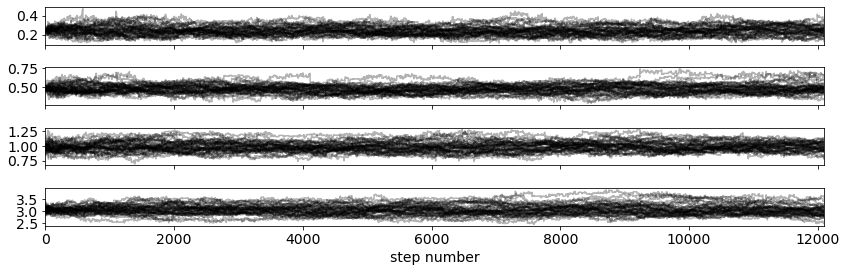

con


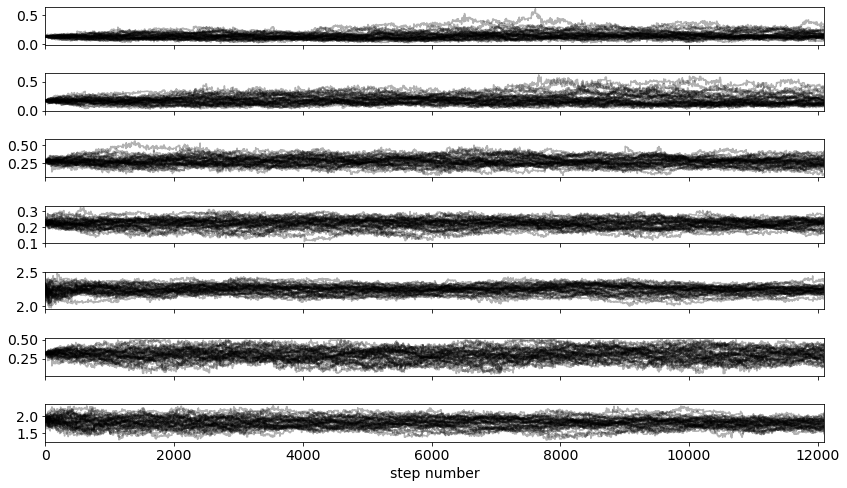

init


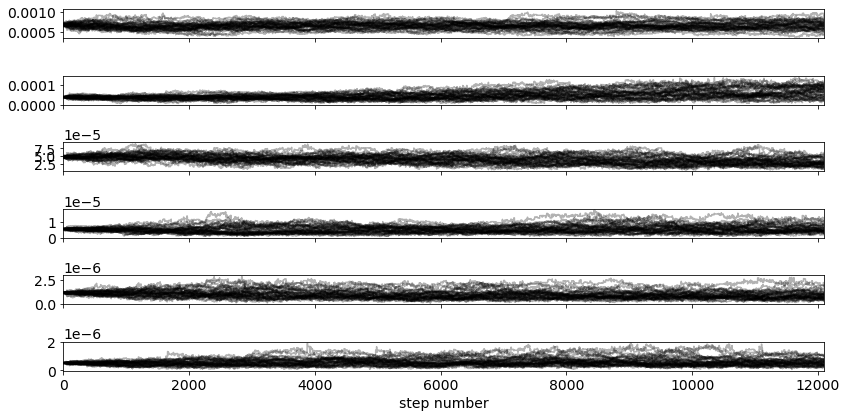

In [12]:
plotInterestingTraces()

## here is the "production" MCMC

In [13]:
if doMCMC :
    
    xArgs = { 
        'nsamples' : prodSamples,
    }
    if nProcMCMC != None : 
        xArgs['nprocesses'] = nProcMCMC

    sampler = estimator.latent_infer_mcmc(obsDeath, fltrDeath, simTime, 
                                        priorsAll, 
                                        initPriorsLinMode, 
                                        generator=contactBasis, 
                                        intervention_fun=interventionFn, 
                                        sampler=sampler,
                                        tangent=False, 
                                        verbose=True, 
                                        **xArgs,
                                        #nsamples=runSamp,
                                        #processes=nProcMCMC,
                                    )
    
    dumpPickle(sampler)
    


In [14]:
if doMCMC : plotInterestingTraces()

### MCMC is done now

sanity check for results : reload `sampler` for analysis 

In [15]:
[sampler,infResult] = loadPickle()
#print(infResult)

ipf ewMod-tWin09-mcmc.pik


### inspect some log-posterior values

In [16]:
pp = sampler.get_log_prob()
showLogProb = True
if showLogProb :
    print(np.shape(pp))
    print(pp[-1],np.size(pp[-1]))

nSampleTot = np.shape(pp)[0]

(12100, 94)
[-233.451 -244.086 -229.415 -227.143 -230.445 -224.675 -230.661 -227.447
 -247.12  -226.618 -224.721 -231.332 -223.259 -232.26  -229.425 -229.017
 -232.207 -229.092 -219.425 -229.294 -235.535 -229.471 -222.655 -234.702
 -222.264 -233.493 -229.909 -228.792 -232.691 -225.812 -227.622 -233.766
 -229.978 -223.787 -236.803 -234.905 -232.774 -229.902 -223.964 -227.94
 -234.156 -234.858 -228.807 -231.626 -224.853 -233.723 -235.677 -238.751
 -237.752 -227.678 -236.082 -233.011 -224.239 -225.148 -233.278 -226.376
 -229.493 -224.256 -238.292 -230.58  -238.345 -229.13  -232.316 -234.022
 -227.493 -228.073 -232.047 -224.46  -227.764 -231.839 -223.466 -225.779
 -229.97  -233.743 -232.725 -237.202 -227.185 -236.148 -226.587 -230.81
 -228.773 -228.804 -230.424 -233.223 -225.85  -223.803 -230.264 -235.41
 -222.845 -232.478 -235.461 -229.704 -226.73  -229.366] 94


### collect results

In [17]:
result_mcmc = estimator.latent_infer_mcmc_process_result(sampler, obsDeath, fltrDeath, 
                                        priorsAll, 
                                        initPriorsLinMode, 
                                        generator=contactBasis, 
                                        intervention_fun=interventionFn, 
                                        discard=int(nSampleTot/3), 
                                        thin=int(nSampleTot/10) )

param_post_mean = pyross.utils.posterior_mean(result_mcmc)

### helper functions to take a quick look at results

In [18]:
def postMeanStd(res,lab,dictLab=None) :
    if dictLab == None : dictLab = 'params_dict'
    mean = np.mean( [ rr[dictLab][lab] for rr in result_mcmc ] )
    std = np.std( [ rr[dictLab][lab] for rr in result_mcmc ] )
    return [mean,std]

def printMeanStd(res,lab,dictLab=None,mult=None,priorM=None,MAP=None) :
    [mean,std] = postMeanStd(res,lab,dictLab)
    myStr = '#post '+lab+' {m:.3f} std {s:.3f}'.format(m=mean,s=std) 
    if priorM != None : myStr += ' priorM {pm:.3f}'.format(pm=priorM)
    if MAP != None : myStr += ' MAP {map:.3f}'.format(map=MAP)
    if mult != None : myStr += ' (mult {mm:.3f}): {m:.3f} std {s:.3f}'.format(mm=mult,m=mean*mult,s=std*mult)
    print(myStr)

def printMeanStdMTime(res,lab,dictLab=None) :
    [mean,std] = postMeanStd(res,lab,dictLab)
    print('#post',lab,'{m:.3f} std {s:.3f} mt {t:.3f}'.format(m=mean,s=std,
                                                             t=daysPerWeek/mean))

In [19]:
ss = np.shape(sampler.get_log_prob())
print('## MCMC run length',ss[0])

printMeanStdMTime(result_mcmc,'gammaE')
printMeanStdMTime(result_mcmc,'gammaA')
printMeanStdMTime(result_mcmc,'gammaIs1')
printMeanStdMTime(result_mcmc,'gammaIs2')
printMeanStdMTime(result_mcmc,'gammaIs3')
print("## [ mt : mean time in days associated with rate gamma (which has units of 'per week') ]")
print("")

printMeanStd(result_mcmc,'betaLateFactor',
             priorM=priorsAll['betaLateFactor']['mean'],
             MAP=infResult['params_dict']['betaLateFactor'])
print("\n## loc and width : t_Lock and W_Lock")
printMeanStd(result_mcmc,'loc',  dictLab='control_params_dict',mult=7.0,
             priorM=priorsAll['loc']['mean'],
             MAP=infResult['control_params_dict']['loc'])

printMeanStd(result_mcmc,'width',dictLab='control_params_dict',mult=7.0,
             priorM=priorsAll['width']['mean'],
             MAP=infResult['control_params_dict']['width'])

print("\n## easing r")
printMeanStd(result_mcmc,'easeFrac',dictLab='control_params_dict',mult=None,
             priorM=priorsAll['easeFrac']['mean'],
             MAP=infResult['control_params_dict']['easeFrac'])

## MCMC run length 12100
#post gammaE 2.050 std 0.202 mt 3.414
#post gammaA 2.986 std 0.268 mt 2.344
#post gammaIs1 2.489 std 0.222 mt 2.813
#post gammaIs2 0.965 std 0.102 mt 7.253
#post gammaIs3 0.965 std 0.101 mt 7.251
## [ mt : mean time in days associated with rate gamma (which has units of 'per week') ]

#post betaLateFactor 0.105 std 0.023 priorM 0.100 MAP 0.106

## loc and width : t_Lock and W_Lock
#post loc 2.246 std 0.062 priorM 2.429 MAP 2.227 (mult 7.000): 15.719 std 0.436
#post width 1.808 std 0.135 priorM 1.714 MAP 1.834 (mult 7.000): 12.659 std 0.945

## easing r
#post easeFrac 0.299 std 0.081 priorM 0.200 MAP 0.311
